In [1]:
import torch
import torch.nn as nn
from torchvision import transforms

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data

In [3]:
x_train = pd.read_csv("/kaggle/input/mnist-9x9/data/X_train.csv").to_numpy().flatten().tolist()
x_test = pd.read_csv("/kaggle/input/mnist-9x9/data/X_test.csv").to_numpy().flatten().tolist()
labels = torch.load("/kaggle/input/mnist-9x9/data/one_hot_10.pt").argmax(dim=-1)

## Dataloader

In [4]:
class DigitDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, is_train=True):
        self.x = x[:int(len(x) * 0.8)] if is_train else x[int(len(x) * 0.8):]
        self.y = y
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        im = Image.open(f"/kaggle/input/mnist-9x9/dataset/{self.x[idx]}.png")
        if self.transform:
            im = self.transform(im)
        return im, self.y[self.x[idx]]

In [5]:
train_ds = DigitDataset(x_train, labels, is_train=True)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_ds = DigitDataset(x_train, labels, is_train=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the shape of the data
x, y = train_ds[0]
x.shape, y.shape

(torch.Size([1, 272, 272]), torch.Size([9, 9]))

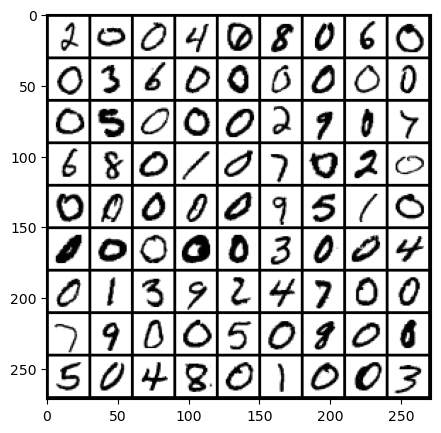

tensor([[2, 0, 0, 4, 0, 8, 0, 6, 0],
        [0, 3, 6, 0, 0, 0, 0, 0, 0],
        [0, 5, 0, 0, 0, 2, 9, 0, 7],
        [6, 8, 0, 1, 0, 7, 0, 2, 0],
        [0, 0, 0, 0, 0, 9, 5, 1, 0],
        [0, 0, 0, 0, 0, 3, 0, 0, 4],
        [0, 1, 3, 9, 2, 4, 7, 0, 0],
        [7, 9, 0, 0, 5, 0, 8, 0, 0],
        [5, 0, 4, 8, 0, 1, 0, 0, 3]])

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(x.numpy().squeeze(), cmap="gray")
plt.show()
y

In [7]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(9),
            nn.Conv2d(256, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 10, kernel_size=1, stride=1),
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        return x

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
model = DigitClassifier()
model.to(device)
print(f"Model has {count_parameters(model)/1e6:.2f}M trainable parameters")

# Check the shape of the output
with torch.no_grad():
    print(model(x.to(device).unsqueeze(0)).shape)

Model has 1.17M trainable parameters
torch.Size([1, 10, 9, 9])


## Training loop

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [11]:
N_EPOCHS = 2

for epoch in range(N_EPOCHS):
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            val_acc += (y_pred.argmax(dim=1) == y).sum().item()
        print(f"Epoch {epoch + 1}/{N_EPOCHS} - val_loss: {val_loss / len(val_loader)} - val_acc: {val_acc / len(val_ds) / 9 / 9}")

  0%|          | 0/168 [00:00<?, ?it/s]

Epoch 1/2 - val_loss: 0.06943986493916739 - val_acc: 0.995365763773724


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch 2/2 - val_loss: 0.04330491496338731 - val_acc: 0.9915883545236779
